In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

import cv2
import numpy as np
import argparse
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
tf.config.list_physical_devices('GPU') 
from tensorflow.keras.applications import VGG16,InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
import seaborn as sn
import itertools
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Add, Activation, Multiply, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load the image data and train a model

In [ ]:
train_path = '/content/drive/My Drive/final_dataset/test'
test_path = '/content/drive/My Drive/final_dataset/train'
val_path = '/content/drive/My Drive/final_dataset/val'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
 validation_split = 0,
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (320, 320),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)
val_generator = test_datagen.flow_from_directory(val_path,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 650 images belonging to 2 classes.
Found 5422 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [ ]:
train_data_dist=np.unique(train_generator.classes, return_counts=True)[1]
class_mapping_train = train_generator.class_indices
for key, val in class_mapping_train.items():
    print(f'The number of {key} images are {train_data_dist[val]} in training-set')
print('_____________________________________________________________________')
test_data_dist=np.unique(test_generator.classes, return_counts=True)[1]
class_mapping_test = test_generator.class_indices
for key, val in class_mapping_test.items():
    print(f'The number of {key} images are {test_data_dist[val]} in test-set')
print('_____________________________________________________________________')
val_data_dist=np.unique(val_generator.classes, return_counts=True)[1]
class_mapping_val = val_generator.class_indices
for key, val in class_mapping_val.items():
    print(f'The number of {key} images are {val_data_dist[val]} in validation-set')

The number of COVID19 images are 19 in training-set
The number of OTHERS images are 631 in training-set
_____________________________________________________________________
The number of COVID19 images are 138 in test-set
The number of OTHERS images are 5284 in test-set
_____________________________________________________________________
The number of COVID19 images are 7 in validation-set
The number of OTHERS images are 19 in validation-set


In [ ]:
basemodel = InceptionV3(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
# basemodel = VGG16(input_tensor=Input(shape=(320, 320, 3)),include_top=False, weights="imagenet")

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=basemodel.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 159, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 159, 159, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 159, 159, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
epochs= 100
lr = 1e-4
BS = 16

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4,decay=lr/epochs),metrics=["accuracy"])

In [ ]:
filepath="best_covid19_imporoved2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Setting class weights to address the imbalance in data

In [ ]:
class_weight = {
    0:0.85,
    1:0.15
}

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch = 320//BS,
                    epochs = epochs,
                    validation_data = val_generator,
                    validation_steps = 26,
                   callbacks=callbacks_list,
                   class_weight=class_weight,
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9750
Epoch 00001: val_accuracy improved from -inf to 0.73077, saving model to best_covid19_imporoved2.h5
20/20 [==============================] - 103s 5s/step - loss: 0.0676 - accuracy: 0.9750 - val_loss: 4.2958 - val_accuracy: 0.7308
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9844
Epoch 00002: val_accuracy did not improve from 0.73077
20/20 [==============================] - 46s 2s/step - loss: 0.0121 - accuracy: 0.9844 - val_loss: 6.5628 - val_accuracy: 0.7308
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9781
Epoch 00003: val_accuracy did not improve from 0.73077
20/20 [==============================] - 49s 2s/step - loss: 0.0147 - accuracy: 0.9781 - val_loss: 5.9569 - val_accuracy: 0.7308
Epoch 4/100
20/20 [======================

# Evaluating trained model on test-set

In [ ]:
filepath = '/content/best_covid19_imporoved2.h5'
new_model = load_model(filepath)

In [ ]:
prediction=new_model.predict(test_generator, use_multiprocessing=True)
print(prediction)

[[9.99892831e-01 1.07125205e-04]
 [9.99980927e-01 1.91242834e-05]
 [9.98820007e-01 1.17992447e-03]
 ...
 [9.63976681e-01 3.60232592e-02]
 [9.99818504e-01 1.81506839e-04]
 [9.99991775e-01 8.18398075e-06]]


## Make Confusion Matrix

Confusion matrix, without normalization


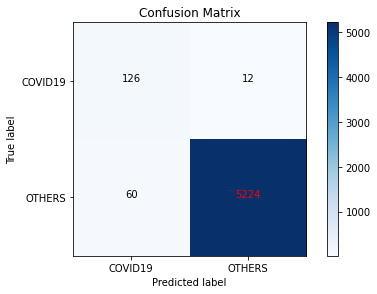

Normalized confusion matrix


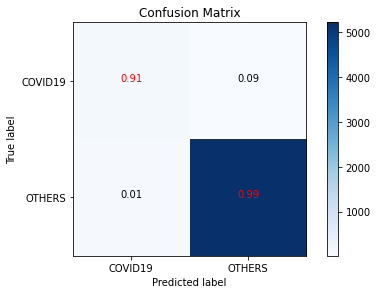

In [ ]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
y_pred = np.argmax(prediction, axis=1)
cm=confusion_matrix(test_generator.classes, y_pred)
cm_labels= ['COVID19','OTHERS']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix')
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix', normalize=True)

## Show the prediction of model on some images of test-set

prob:[9.99892831e-01 1.07125205e-04]
COVID19/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg


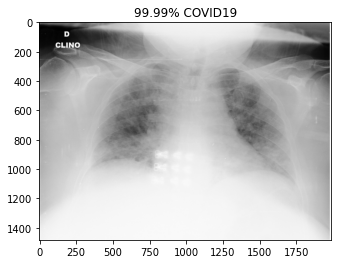

prob:[9.9998093e-01 1.9124283e-05]
COVID19/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg


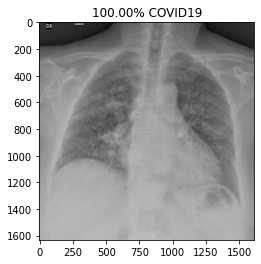

prob:[0.99882    0.00117992]
COVID19/1-s2.0-S0140673620303706-fx1_lrg.jpg


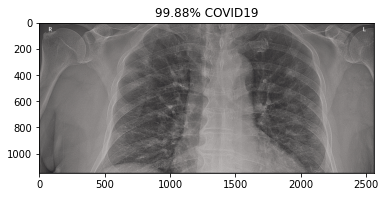

prob:[9.9994075e-01 5.9255821e-05]
COVID19/1-s2.0-S0929664620300449-gr2_lrg-c.jpg


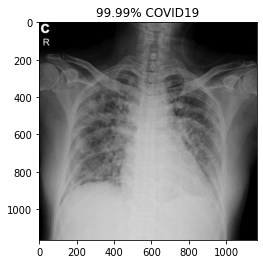

prob:[9.9996674e-01 3.3273416e-05]
COVID19/1-s2.0-S0929664620300449-gr3_lrg-a.jpg


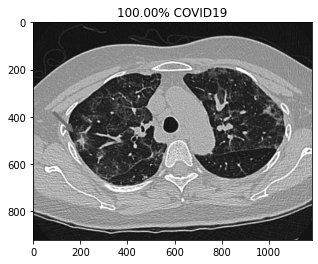

prob:[9.9998403e-01 1.5919668e-05]
COVID19/1-s2.0-S0929664620300449-gr3_lrg-b.jpg


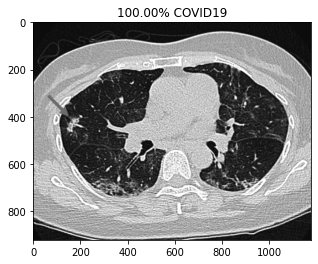

prob:[9.9997461e-01 2.5334555e-05]
COVID19/1-s2.0-S0929664620300449-gr3_lrg-c.jpg


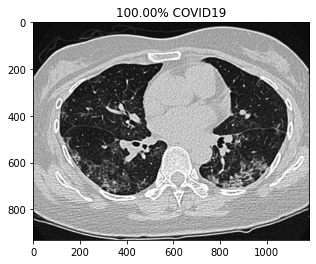

prob:[9.9966121e-01 3.3876425e-04]
COVID19/1-s2.0-S1684118220300608-main.pdf-001.jpg


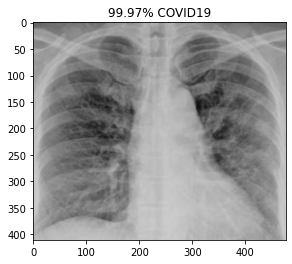

prob:[0.88963246 0.11036746]
COVID19/1-s2.0-S1684118220300682-main.pdf-002-a1.png


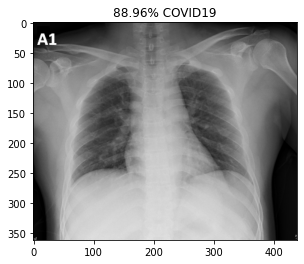

prob:[0.06493094 0.935069  ]
COVID19/1-s2.0-S1684118220300682-main.pdf-002-a2.png


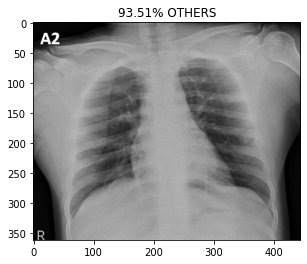

prob:[0.9882144  0.01178567]
COVID19/1-s2.0-S1684118220300682-main.pdf-003-b1.png


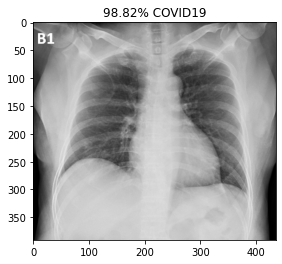

prob:[0.60393834 0.39606163]
COVID19/1-s2.0-S1684118220300682-main.pdf-003-b2.png


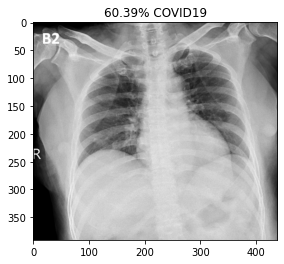

prob:[0.96917444 0.03082558]
COVID19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png


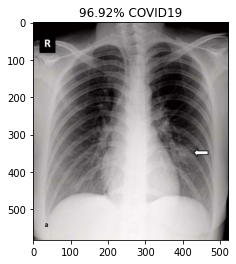

prob:[0.9558261  0.04417395]
COVID19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1b.png


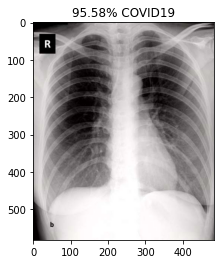

prob:[0.9868134  0.01318656]
COVID19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2a.png


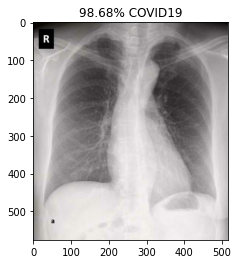

prob:[0.9874428  0.01255721]
COVID19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2b.png


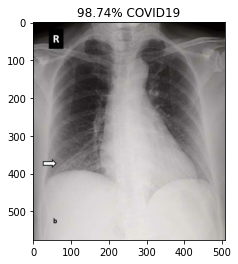

prob:[0.9321709  0.06782909]
COVID19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3a.png


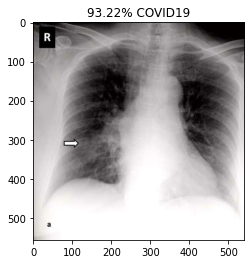

prob:[0.96588266 0.0341173 ]
COVID19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3b.png


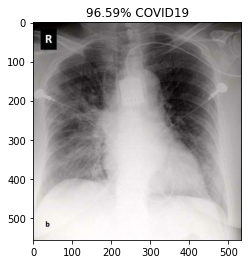

prob:[0.98034567 0.01965433]
COVID19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4a.png


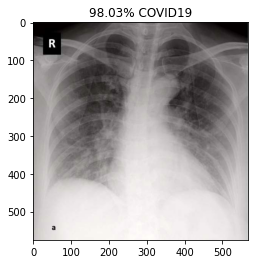

prob:[0.9688456 0.0311544]
COVID19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4b.png


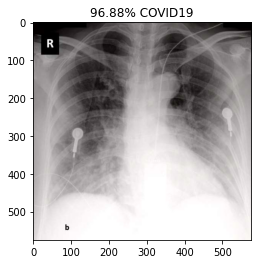

prob:[0.7107685  0.28923148]
COVID19/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg


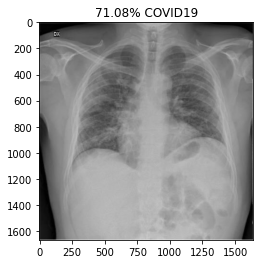

prob:[9.9982291e-01 1.7717067e-04]
COVID19/171CB377-62FF-4B76-906C-F3787A01CB2E.jpeg


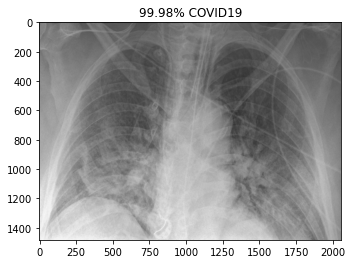

prob:[9.999809e-01 1.908302e-05]
COVID19/191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg


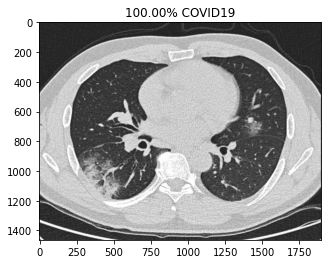

prob:[9.999926e-01 7.436903e-06]
COVID19/1F6343EE-AFEC-4B7D-97F5-62797EE18767.jpeg


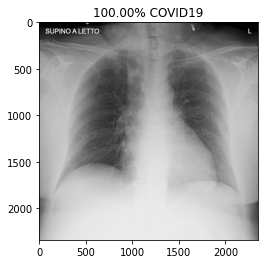

prob:[0.3171684 0.6828316]
COVID19/23E99E2E-447C-46E5-8EB2-D35D12473C39.png


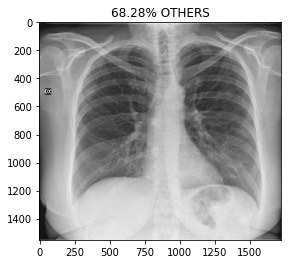

prob:[9.9999344e-01 6.5379554e-06]
COVID19/2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg


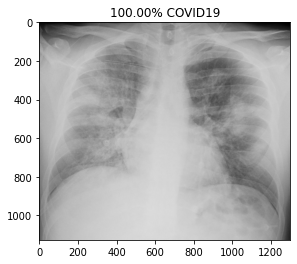

prob:[9.9996853e-01 3.1522948e-05]
COVID19/2B8649B2-00C4-4233-85D5-1CE240CF233B.jpeg


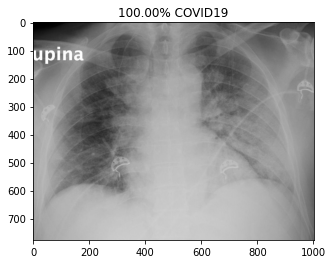

prob:[9.9994767e-01 5.2325169e-05]
COVID19/2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg


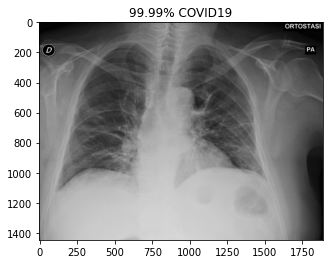

prob:[0.9979291  0.00207095]
COVID19/31BA3780-2323-493F-8AED-62081B9C383B.jpeg


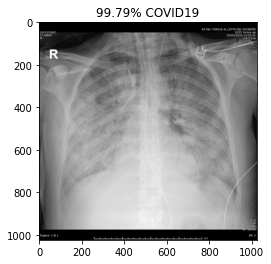

prob:[0.9892189  0.01078113]
COVID19/353889E0-A1E8-4F9E-A0B8-F24F36BCFBFB.jpeg


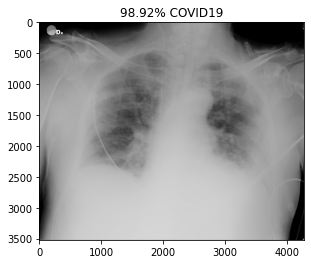

In [ ]:
import cv2
import matplotlib.image as mpimg
prediction = prediction[:30]
for index, probability in enumerate(prediction):
    image_path = test_path + "/" +test_generator.filenames[index]
    image = mpimg.imread(image_path)
     #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = np.array(image)
    plt.imshow(pixels)
    print("prob:{}".format(probability))
    print(test_generator.filenames[index])
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% OTHERS')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% COVID19')
    plt.show()

## Plotting ROC curve and generating classification report

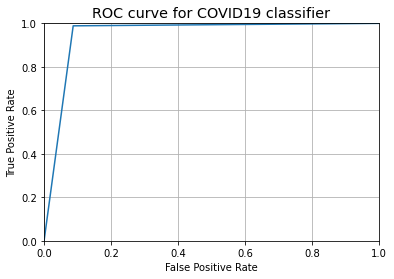

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for COVID19 classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
print('Classification Report')
target_names = ['COVID19','OTHERS']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     COVID19       0.68      0.91      0.78       138
      OTHERS       1.00      0.99      0.99      5284

    accuracy                           0.99      5422
   macro avg       0.84      0.95      0.89      5422
weighted avg       0.99      0.99      0.99      5422

